# Object Detection as a Machine Learning Problem

In this notebook, we'll break down object detection into its core components and demonstrate how it works as a machine learning problem. We'll use our synthetic shape dataset to visualize three key aspects:

1. **Bounding Box Regression**: Predicting the coordinates of object boundaries as a regression problem
2. **Binary Classification**: Determining whether an object exists in a predicted region  
3. **Multi-class Classification**: Identifying the specific class/type of the detected object

Let's explore each component step by step and see how they work together to solve the object detection problem.

In [12]:
# Import Required Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import random
import math
from typing import Tuple, List, Dict

# Import our dataset generator
from dataset_generation import ShapeDatasetGenerator

# Set random seed for reproducible results
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


Generating 20 images with up to 1 objects each...
Generated 10/20 images
Generated 20/20 images
Successfully generated 20 images.
Generated 20 sample images
Sample images with ground truth bounding boxes:


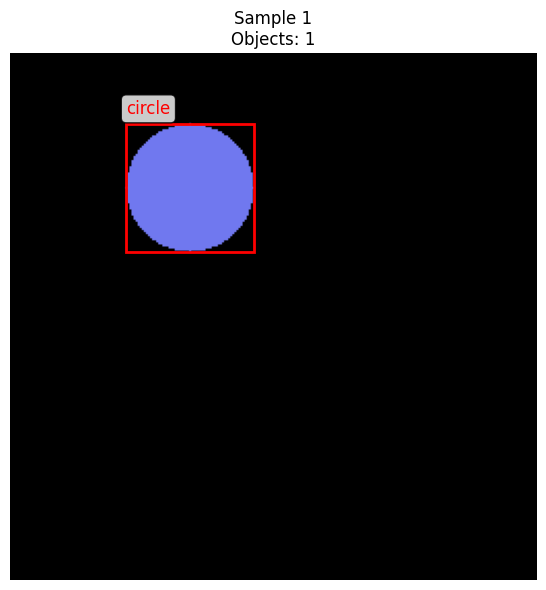

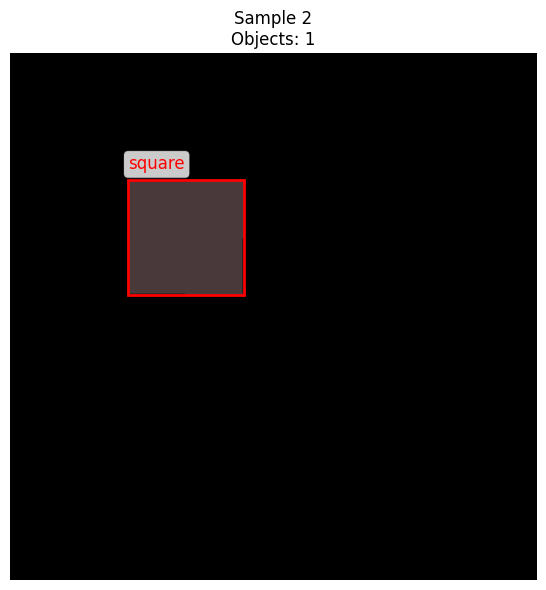

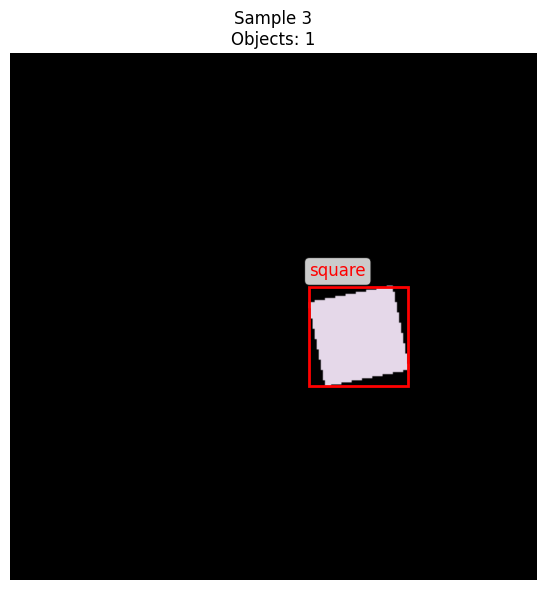

In [13]:
# Generate Sample Dataset
generator = ShapeDatasetGenerator(img_size=256, margin=30)
dataset = generator.generate_dataset(num_images=20, max_objects_per_image=1, allow_empty_images=False)

print(f"Generated {len(dataset)} sample images")

# Function to visualize images with bounding boxes
def visualize_with_bbox(sample, title=""):
    image = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(image)
    
    # Draw bounding boxes for all objects
    for obj in sample['objects']:
        x1, y1, x2, y2 = obj['bbox']
        width = x2 - x1
        height = y2 - y1
        
        # Draw bounding box
        rect = Rectangle((x1, y1), width, height, 
                        linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Add class label
        ax.text(x1, y1-5, obj['class'], fontsize=12, color='red', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    ax.set_title(f"{title}\nObjects: {sample['num_objects']}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a few samples with ground truth bounding boxes
print("Sample images with ground truth bounding boxes:")
for i in range(3):
    visualize_with_bbox(dataset[i], f"Sample {i+1}")

## 1. Bounding Box Regression Problem

The first component of object detection is **bounding box regression** - predicting the coordinates that define where an object is located in the image.

### Key Concepts:
- **Input**: Image features (typically from a CNN backbone)
- **Output**: 4 continuous values representing bounding box coordinates (x1, y1, x2, y2)
- **Loss Function**: Usually Mean Squared Error (MSE) or Smooth L1 Loss
- **Problem Type**: Regression (predicting continuous numerical values)

Let's visualize how this works with our dataset:

### What Do the Four Bounding Box Numbers Mean?
- **x1, y1**: Coordinates of the top-left corner of the bounding box.
- **x2, y2**: Coordinates of the bottom-right corner of the bounding box.

These four numbers define the rectangle that surrounds the detected object:
- (x1, y1) is the top-left corner.
- (x2, y2) is the bottom-right corner.

The regression model predicts these four values to localize the object in the image.

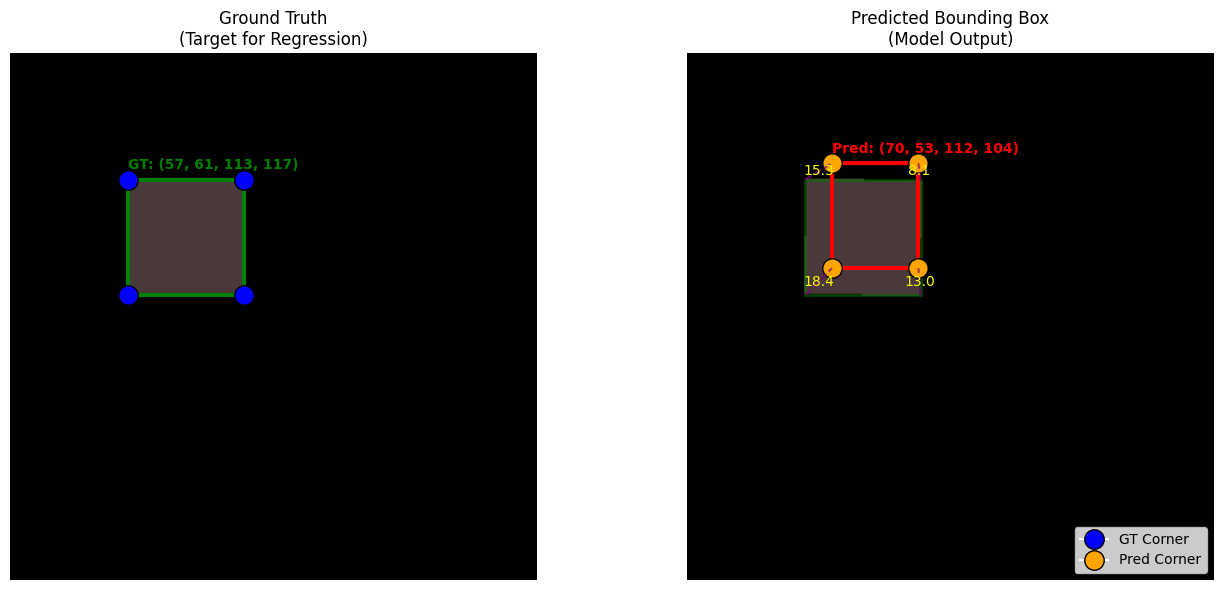

Regression Loss (MSE): 100.75
Ground Truth: (57, 61, 113, 117)
Predicted:    [70, 53, 112, 104]
Distances between corresponding corners (pixels):
Corner 1: 15.26
Corner 2: 8.06
Corner 3: 13.04
Corner 4: 18.38


In [32]:
# Simulate bounding box predictions for demonstration
def simulate_bbox_predictions(ground_truth_bbox, noise_level=10):
    """Simulate predicted bounding boxes by adding noise to ground truth"""
    x1, y1, x2, y2 = ground_truth_bbox
    
    # Add random noise to simulate prediction errors
    pred_x1 = max(0, x1 + np.random.randint(-noise_level, noise_level))
    pred_y1 = max(0, y1 + np.random.randint(-noise_level, noise_level))
    pred_x2 = min(255, x2 + np.random.randint(-noise_level, noise_level))
    pred_y2 = min(255, y2 + np.random.randint(-noise_level, noise_level))
    
    return [pred_x1, pred_y1, pred_x2, pred_y2]

# Visualize ground truth vs predicted bounding boxes and corners
def compare_bbox_regression(sample, pred_bbox):
    image = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Ground Truth
    ax1.imshow(image)
    gt_bbox = sample['objects'][0]['bbox']
    x1, y1, x2, y2 = gt_bbox
    gt_rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                       linewidth=3, edgecolor='green', facecolor='none')
    ax1.add_patch(gt_rect)
    ax1.set_title("Ground Truth\n(Target for Regression)")
    ax1.text(x1, y1-5, f"GT: ({x1}, {y1}, {x2}, {y2})", 
             fontsize=10, color='green', weight='bold')
    ax1.axis('off')
    # Plot ground truth corners
    gt_corners = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    for i, (cx, cy) in enumerate(gt_corners):
        ax1.plot(cx, cy, 'o', color='blue', markersize=14, markeredgecolor='black', label='GT Corner' if i==0 else None)
    
    # Predicted
    ax2.imshow(image)
    # Add ground truth for comparison (lighter)
    gt_rect2 = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor='green', facecolor='none', alpha=0.5)
    ax2.add_patch(gt_rect2)
    
    # Add predicted bbox
    px1, py1, px2, py2 = pred_bbox
    pred_rect = Rectangle((px1, py1), px2-px1, py2-py1, 
                         linewidth=3, edgecolor='red', facecolor='none')
    ax2.add_patch(pred_rect)
    ax2.set_title("Predicted Bounding Box\n(Model Output)")
    ax2.text(px1, py1-5, f"Pred: ({px1}, {py1}, {px2}, {py2})", 
             fontsize=10, color='red', weight='bold')
    ax2.axis('off')
    # Plot predicted corners with improved visibility
    pred_corners = [(px1, py1), (px2, py1), (px2, py2), (px1, py2)]
    for i, (cx, cy) in enumerate(pred_corners):
        ax2.plot(cx, cy, 'o', color='orange', markersize=14, markeredgecolor='black', label='Pred Corner' if i==0 else None)
    
    # Draw lines between corresponding corners and show distances
    for i, ((gt_x, gt_y), (pr_x, pr_y)) in enumerate(zip(gt_corners, pred_corners)):
        ax2.plot([gt_x, pr_x], [gt_y, pr_y], '--', color='purple', alpha=0.7)
        dist = math.sqrt((gt_x - pr_x)**2 + (gt_y - pr_y)**2)
        ax2.text((gt_x+pr_x)/2, (gt_y+pr_y)/2, f"{dist:.1f}", color='yellow', fontsize=10, ha='center', va='center')
    
    # Add legends for corners
    handles = [plt.Line2D([0], [0], marker='o', color='w', label='GT Corner', markerfacecolor='blue', markeredgecolor='black', markersize=14),
               plt.Line2D([0], [0], marker='o', color='w', label='Pred Corner', markerfacecolor='orange', markeredgecolor='black', markersize=14)]
    ax2.legend(handles=handles, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate regression loss (MSE)
    mse_loss = np.mean([(gt_bbox[i] - pred_bbox[i])**2 for i in range(4)])
    print(f"Regression Loss (MSE): {mse_loss:.2f}")
    print(f"Ground Truth: {gt_bbox}")
    print(f"Predicted:    {pred_bbox}")
    # Print distances between corners
    print("Distances between corresponding corners (pixels):")
    for i, ((gt_x, gt_y), (pr_x, pr_y)) in enumerate(zip(gt_corners, pred_corners)):
        dist = math.sqrt((gt_x - pr_x)**2 + (gt_y - pr_y)**2)
        print(f"Corner {i+1}: {dist:.2f}")

# Demonstrate regression with a sample
sample = dataset[1]
predicted_bbox = simulate_bbox_predictions(sample['objects'][0]['bbox'], noise_level=15)
compare_bbox_regression(sample, predicted_bbox)

## 2. Binary Classification Head - Object Detection

The second component determines **whether an object exists** in a given region. This is a binary classification problem.

### Key Concepts:
- **Input**: Image features from a proposed region
- **Output**: Single probability score (0-1) indicating object presence
- **Loss Function**: Binary Cross Entropy Loss
- **Problem Type**: Binary Classification (object vs. background)

Let's visualize how this works by comparing regions with and without objects:

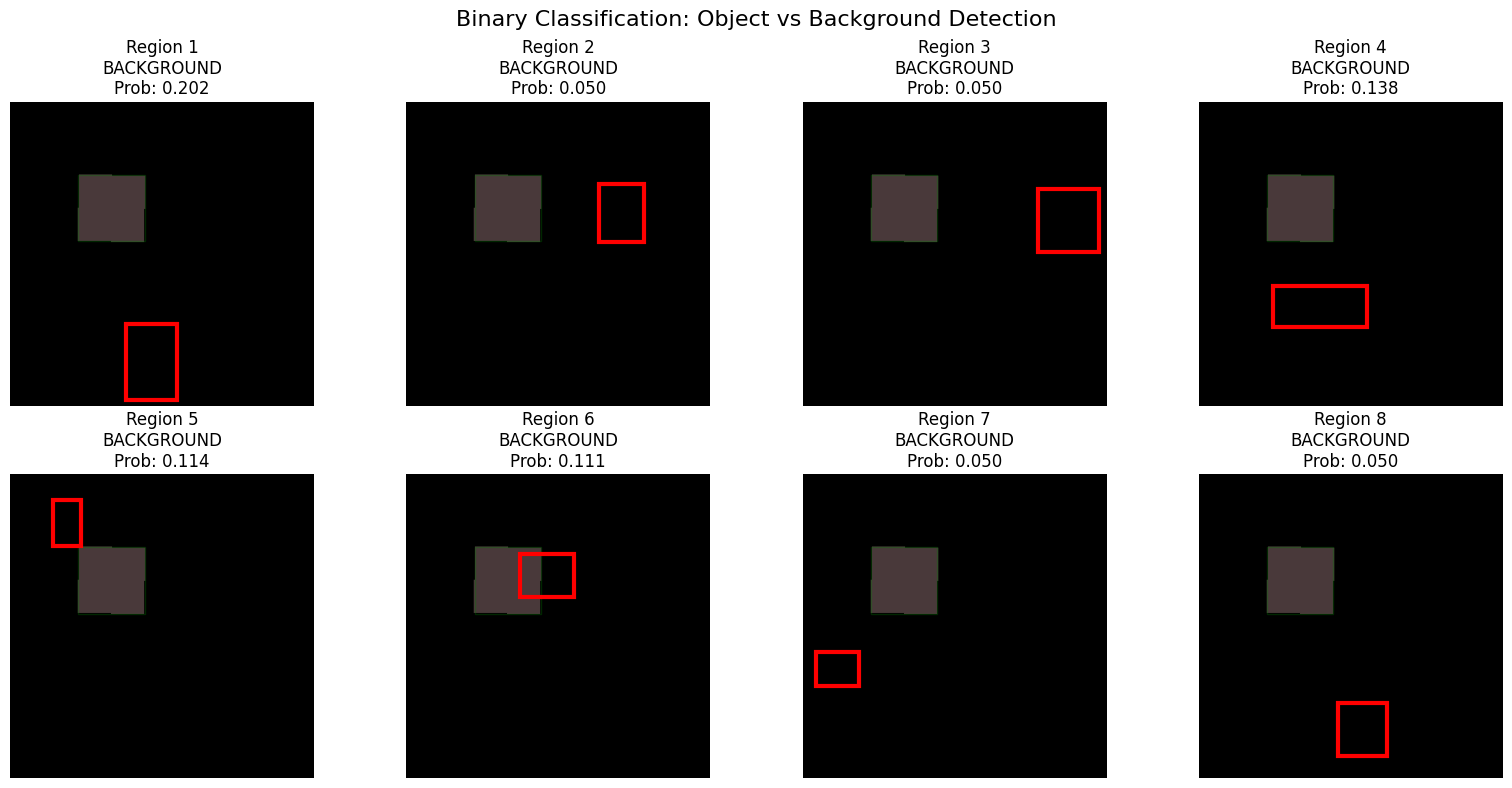

Binary Classification Results:
- Green regions: Contain objects (positive class)
- Red regions: Background only (negative class)
- Probability represents confidence of object presence


In [72]:
# Generate random regions for binary classification demonstration
def generate_random_regions(img_size, num_regions=6):
    """Generate random bounding box regions for classification"""
    regions = []
    for _ in range(num_regions):
        x1 = np.random.randint(0, img_size - 50)
        y1 = np.random.randint(0, img_size - 50)
        x2 = np.random.randint(x1 + 20, min(x1 + 80, img_size))
        y2 = np.random.randint(y1 + 20, min(y1 + 80, img_size))
        regions.append([x1, y1, x2, y2])
    return regions

def calculate_iou(box1, box2):
    """Calculate Intersection over Union between two bounding boxes"""
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    # Calculate intersection
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0

def visualize_binary_classification(sample):
    """Visualize binary classification for object detection"""
    image = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
    gt_bbox = sample['objects'][0]['bbox']
    
    # Generate random regions
    random_regions = generate_random_regions(256, num_regions=8)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, region in enumerate(random_regions):
        ax = axes[i]
        ax.imshow(image)
        
        # Calculate IoU with ground truth
        iou = calculate_iou(region, gt_bbox)
        
        # Determine if this region contains an object (IoU > 0.5 threshold)
        has_object = iou > 0.5
        object_probability = min(0.95, max(0.05, iou + np.random.normal(0, 0.1)))
        
        # Draw ground truth (light green)
        x1, y1, x2, y2 = gt_bbox
        gt_rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=1, edgecolor='green', facecolor='none', alpha=0.3)
        ax.add_patch(gt_rect)
        
        # Draw proposed region
        rx1, ry1, rx2, ry2 = region
        color = 'darkgreen' if has_object else 'red'
        region_rect = Rectangle((rx1, ry1), rx2-rx1, ry2-ry1, 
                               linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(region_rect)
        
        # Add classification result
        label = "OBJECT" if has_object else "BACKGROUND"
        ax.set_title(f"Region {i+1}\n{label}\nProb: {object_probability:.3f}")
        ax.axis('off')
    
    plt.suptitle("Binary Classification: Object vs Background Detection", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("Binary Classification Results:")
    print("- Green regions: Contain objects (positive class)")
    print("- Red regions: Background only (negative class)")
    print("- Probability represents confidence of object presence")

# Demonstrate binary classification
sample = dataset[1]
visualize_binary_classification(sample)

## 3. Multi-class Classification Head - Object Recognition

The third component identifies **what type of object** has been detected. This is a multi-class classification problem.

### Key Concepts:
- **Input**: Image features from a detected object region
- **Output**: Probability distribution over all possible object classes
- **Loss Function**: Categorical Cross Entropy Loss
- **Problem Type**: Multi-class Classification (circle, rectangle, triangle, etc.)

Let's visualize how this works with our shape classes:

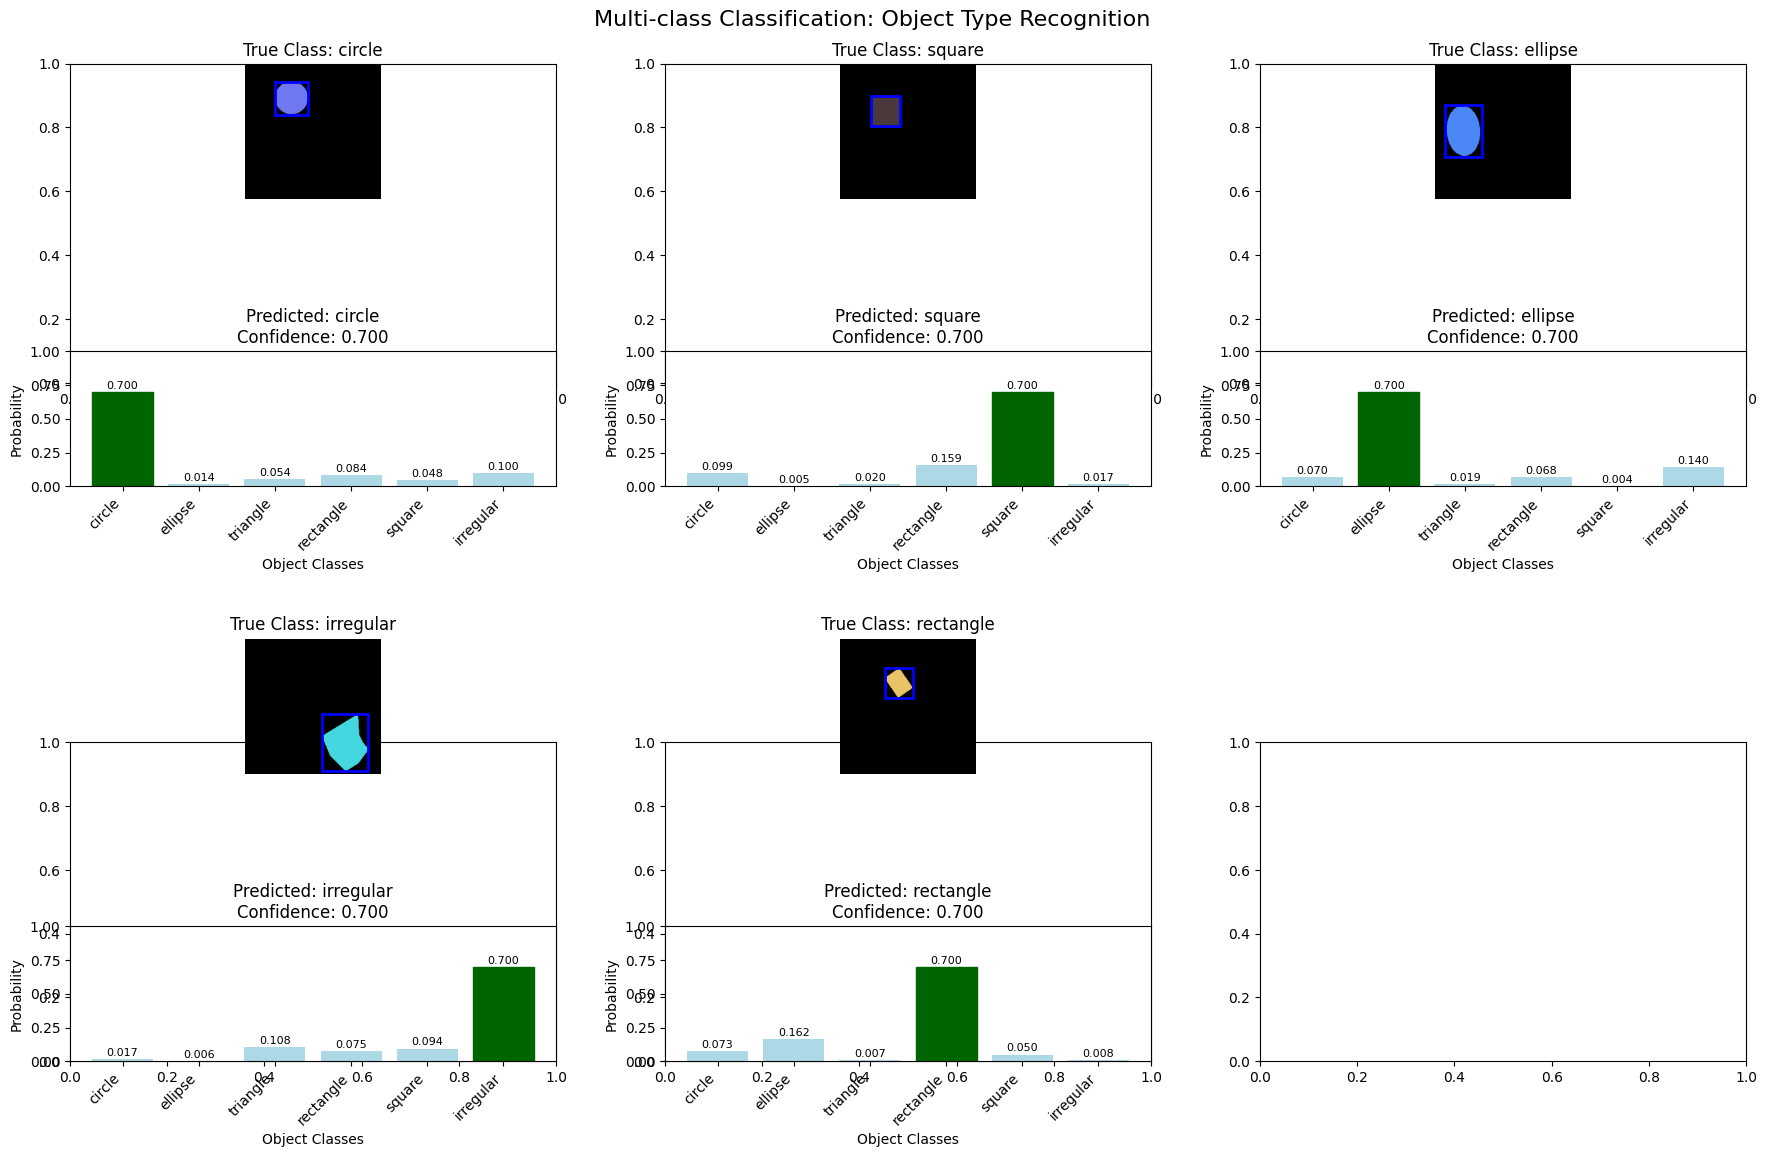

Multi-class Classification Results:
- Green bars: True class (ground truth)
- Blue bars: Other possible classes
- Height: Probability/confidence for each class
- Model predicts the class with highest probability


In [83]:
# Define all possible classes in our dataset
ALL_CLASSES = ['circle', 'ellipse', 'triangle', 'rectangle', 'square', 'irregular']

def simulate_class_predictions(true_class, confidence=0.8):
    """Simulate class probability predictions"""
    # Start with random probabilities
    probs = np.random.dirichlet(np.ones(len(ALL_CLASSES)))
    
    # Boost the probability of the true class
    true_idx = ALL_CLASSES.index(true_class) if true_class in ALL_CLASSES else 0
    probs[true_idx] = confidence
    
    # Normalize the rest
    remaining_prob = 1.0 - confidence
    other_indices = [i for i in range(len(ALL_CLASSES)) if i != true_idx]
    remaining_probs = np.random.dirichlet(np.ones(len(other_indices))) * remaining_prob
    
    for i, idx in enumerate(other_indices):
        probs[idx] = remaining_probs[i]
    
    return probs

def visualize_multiclass_classification():
    """Visualize multi-class classification results"""
    # Select samples with different classes
    samples_by_class = {}
    for sample in dataset:
        if sample['num_objects'] > 0:
            obj_class = sample['objects'][0]['class']
            base_class = obj_class.split('_')[0]  # Remove irregular suffix
            if base_class not in samples_by_class:
                samples_by_class[base_class] = sample
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    plot_idx = 0
    for class_name, sample in list(samples_by_class.items())[:6]:
        row = plot_idx // 3
        col = plot_idx % 3
        
        # Top subplot: Image with bounding box
        ax_img = plt.subplot2grid((4, 3), (row*2, col))
        image = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
        ax_img.imshow(image)
        
        # Draw bounding box
        bbox = sample['objects'][0]['bbox']
        x1, y1, x2, y2 = bbox
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor='blue', facecolor='none')
        ax_img.add_patch(rect)
        ax_img.set_title(f"True Class: {class_name}")
        ax_img.axis('off')
        
        # Bottom subplot: Class probability distribution
        ax_prob = plt.subplot2grid((4, 3), (row*2+1, col))
        
        # Simulate predictions
        predicted_probs = simulate_class_predictions(class_name, confidence=0.7)
        
        # Create bar plot
        bars = ax_prob.bar(range(len(ALL_CLASSES)), predicted_probs, 
                          color=['green' if cls == class_name else 'lightblue' for cls in ALL_CLASSES])
        
        # Highlight the true class
        true_idx = ALL_CLASSES.index(class_name) if class_name in ALL_CLASSES else 0
        bars[true_idx].set_color('darkgreen')
        
        ax_prob.set_xlabel('Object Classes')
        ax_prob.set_ylabel('Probability')
        ax_prob.set_title(f'Predicted: {ALL_CLASSES[np.argmax(predicted_probs)]}\n'
                         f'Confidence: {max(predicted_probs):.3f}')
        ax_prob.set_xticks(range(len(ALL_CLASSES)))
        ax_prob.set_xticklabels(ALL_CLASSES, rotation=45, ha='right')
        ax_prob.set_ylim(0, 1)
        
        # Add probability values on bars
        for i, prob in enumerate(predicted_probs):
            ax_prob.text(i, prob + 0.01, f'{prob:.3f}', 
                        ha='center', va='bottom', fontsize=8)
        
        plot_idx += 1
    
    plt.suptitle("Multi-class Classification: Object Type Recognition", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("Multi-class Classification Results:")
    print("- Green bars: True class (ground truth)")
    print("- Blue bars: Other possible classes")
    print("- Height: Probability/confidence for each class")
    print("- Model predicts the class with highest probability")

# Demonstrate multi-class classification
visualize_multiclass_classification()

## 4. Combined Model Architecture - Putting It All Together

Now let's see how all three components work together in a complete object detection system:

### Complete Pipeline:
1. **Feature Extraction**: CNN backbone extracts features from input image
2. **Region Proposal**: Generate candidate regions (bounding boxes)
3. **Regression Head**: Refine bounding box coordinates  
4. **Binary Classification**: Determine if region contains an object
5. **Multi-class Classification**: Identify the object type

Let's create a comprehensive visualization showing this complete process:

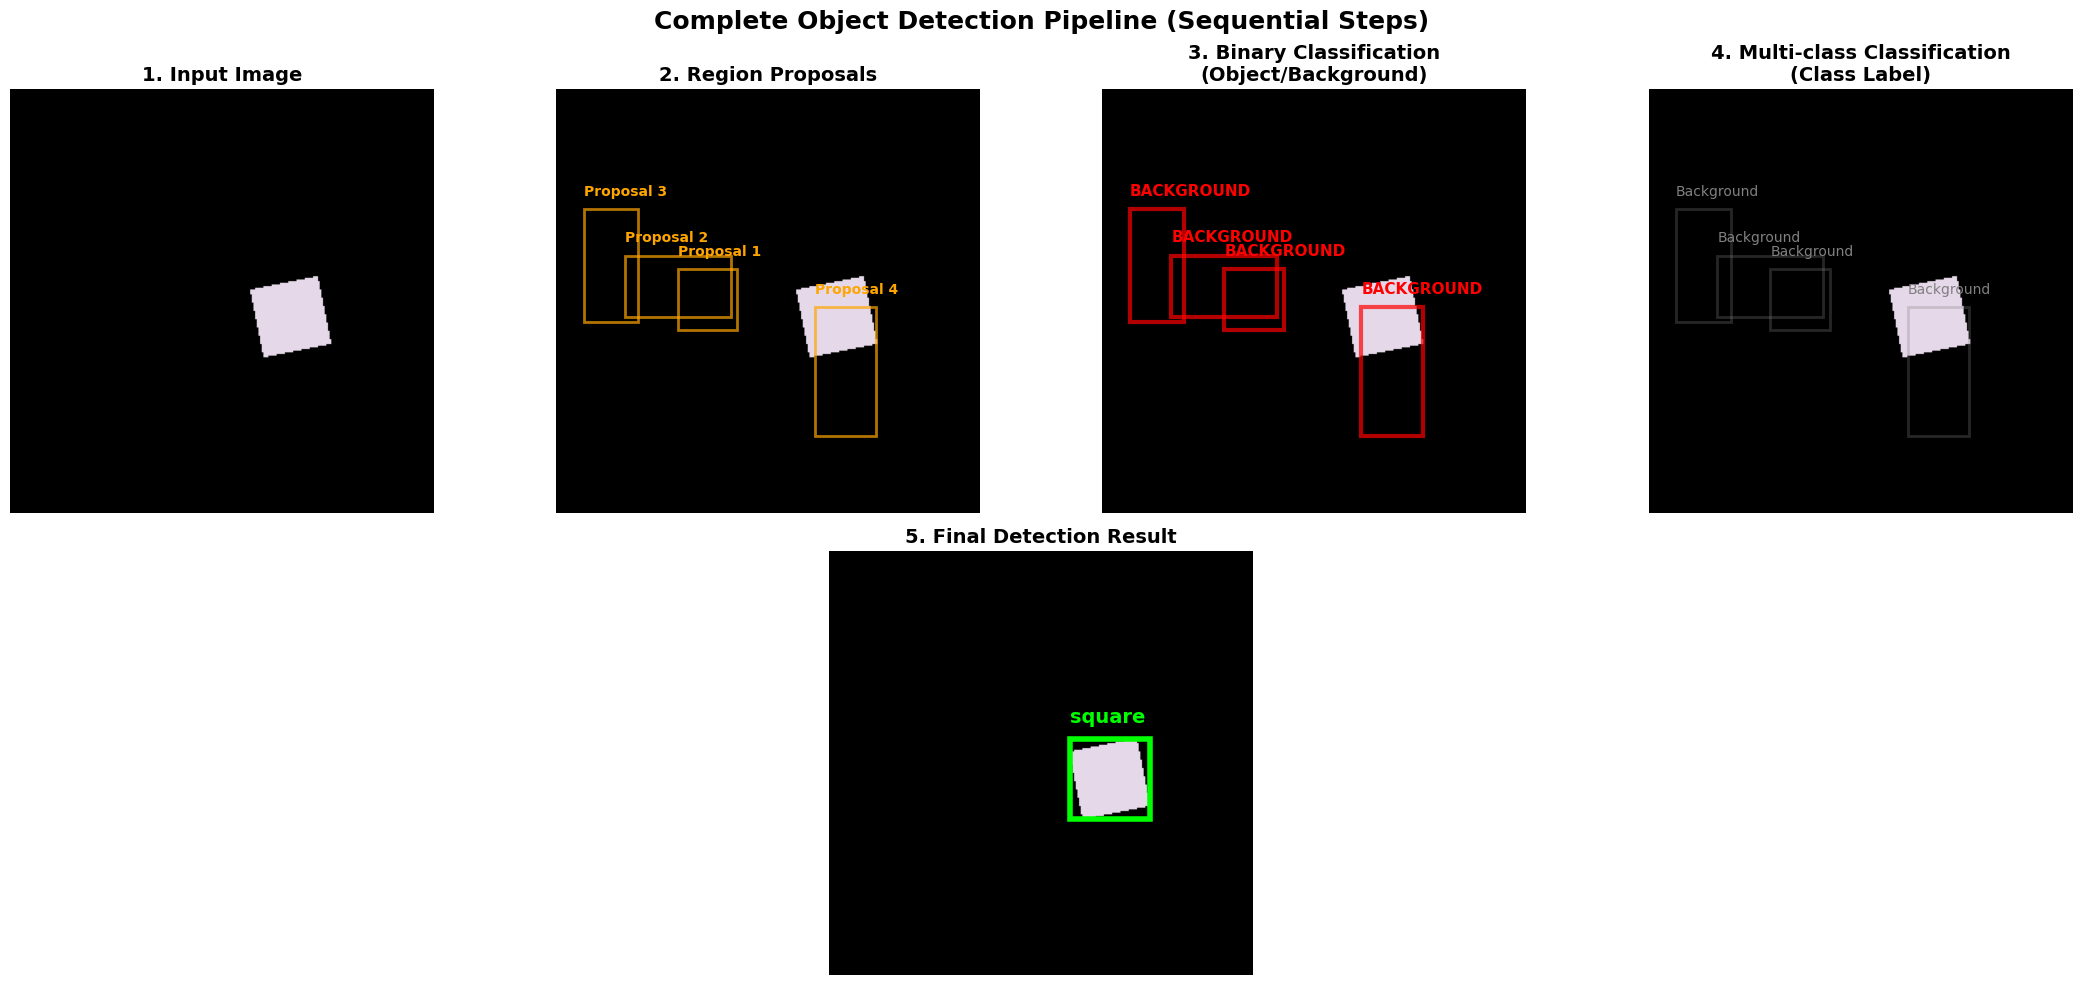


OBJECT DETECTION PIPELINE SUMMARY
Input: 256x256 RGB image
Ground Truth: square at (145, 113, 193, 161)
Predicted Class: square
Predicted Box: (145, 113, 193, 161)

Pipeline Components:
✓ 1. Feature Extraction (CNN backbone)
✓ 2. Region Proposal Network
✓ 3. Bounding Box Regression
✓ 4. Binary Classification (object detection)
✓ 5. Multi-class Classification (object recognition)


In [ ]:
# Complete Object Detection Pipeline Visualization

def visualize_complete_pipeline(sample):
    """Visualize the complete object detection pipeline as a sequential process with arrows and logical progression"""
    image = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
    gt_bbox = sample['objects'][0]['bbox']
    gt_class = sample['objects'][0]['class'].split('_')[0]
    ALL_CLASSES = ['circle', 'ellipse', 'triangle', 'rectangle', 'square', 'irregular']

    fig = plt.figure(figsize=(22, 10))

    # 1. Original Image
    ax1 = plt.subplot2grid((2, 4), (0, 0))
    ax1.imshow(image)
    ax1.set_title("1. Input Image", fontsize=14, weight='bold')
    ax1.axis('off')

    # 2. Region Proposals
    ax2 = plt.subplot2grid((2, 4), (0, 1))
    ax2.imshow(image)
    proposals = generate_random_regions(256, 4)
    for i, prop in enumerate(proposals):
        x1, y1, x2, y2 = prop
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='orange', facecolor='none', alpha=0.7)
        ax2.add_patch(rect)
        ax2.text(x1, y1-8, f"Proposal {i+1}", color='orange', fontsize=10, weight='bold')
    ax2.set_title("2. Region Proposals", fontsize=14, weight='bold')
    ax2.axis('off')

    # 3. Binary Classification (Object/Background)
    ax3 = plt.subplot2grid((2, 4), (0, 2))
    ax3.imshow(image)
    found_object = False
    object_proposal = None
    for i, prop in enumerate(proposals):
        x1, y1, x2, y2 = prop
        iou = calculate_iou(prop, gt_bbox)
        has_object = iou > 0.3
        color = 'green' if has_object else 'red'
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor=color, facecolor='none', alpha=0.7)
        ax3.add_patch(rect)
        label = "OBJECT" if has_object else "BACKGROUND"
        ax3.text(x1, y1-8, f"{label}", color=color, fontsize=11, weight='bold')
        if has_object and not found_object:
            found_object = True
            object_proposal = prop
    ax3.set_title("3. Binary Classification\n(Object/Background)", fontsize=14, weight='bold')
    ax3.axis('off')

    # Draw arrows between steps
    arrowprops = dict(arrowstyle="->", color="black", linewidth=2)
    fig.canvas.draw()  # Needed for proper axis placement
    # Arrow from ax1 to ax2
    ax1_pos = ax1.get_position()
    ax2_pos = ax2.get_position()
    fig.annotate('', xy=(ax2_pos.x0, ax2_pos.y0+ax2_pos.height/2), xytext=(ax1_pos.x1, ax1_pos.y0+ax1_pos.height/2), arrowprops=arrowprops)
    # Arrow from ax2 to ax3
    ax3_pos = ax3.get_position()
    fig.annotate('', xy=(ax3_pos.x0, ax3_pos.y0+ax3_pos.height/2), xytext=(ax2_pos.x1, ax2_pos.y0+ax2_pos.height/2), arrowprops=arrowprops)

    # 4. Multi-class Classification (Class Label)
    ax4 = plt.subplot2grid((2, 4), (0, 3))
    ax4.imshow(image)
    if found_object:
        x1, y1, x2, y2 = object_proposal
        # Simulate class prediction
        predicted_probs = simulate_class_predictions(gt_class, confidence=0.8)
        predicted_class = ALL_CLASSES[np.argmax(predicted_probs)]
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='blue', facecolor='none', alpha=0.7)
        ax4.add_patch(rect)
        ax4.text(x1, y1-8, f"Class: {predicted_class}", color='blue', fontsize=12, weight='bold')
    else:
        ax4.text(0.5, 0.5, "No object proposal found!", color='red', fontsize=16, weight='bold', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title("4. Multi-class Classification\n(Class Label)", fontsize=14, weight='bold')
    ax4.axis('off')
    # Arrow from ax3 to ax4
    ax4_pos = ax4.get_position()
    fig.annotate('', xy=(ax4_pos.x0, ax4_pos.y0+ax4_pos.height/2), xytext=(ax3_pos.x1, ax3_pos.y0+ax3_pos.height/2), arrowprops=arrowprops)

    # 5. Final Detection Result
    ax5 = plt.subplot2grid((2, 4), (1, 1), colspan=2)
    ax5.imshow(image)
    if found_object:
        x1, y1, x2, y2 = object_proposal
        final_rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=4, edgecolor='lime', facecolor='none')
        ax5.add_patch(final_rect)
        ax5.text(x1, y1-10, f'{predicted_class}', fontsize=14, color='lime', weight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
        ax5.set_title("5. Final Detection Result", fontsize=14, weight='bold')
    else:
        ax5.text(0.5, 0.5, "No detection possible!", color='red', fontsize=16, weight='bold', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title("5. Final Detection Result", fontsize=14, weight='bold')
    ax5.axis('off')
    # Arrow from ax4 to ax5
    ax5_pos = ax5.get_position()
    fig.annotate('', xy=(ax5_pos.x0+ax5_pos.width/2, ax5_pos.y1), xytext=(ax4_pos.x0+ax4_pos.width/2, ax4_pos.y0), arrowprops=arrowprops)

    plt.suptitle("Complete Object Detection Pipeline (Sequential Steps)", fontsize=18, weight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*60)
    print("OBJECT DETECTION PIPELINE SUMMARY")
    print("="*60)
    print(f"Input: {image.shape[0]}x{image.shape[1]} RGB image")
    print(f"Ground Truth: {gt_class} at {gt_bbox}")
    if found_object:
        print(f"Predicted Class: {predicted_class}")
        print(f"Predicted Box: {object_proposal}")
    else:
        print("No detection possible!")
    print("\nPipeline Components:")
    print("✓ 1. Feature Extraction (CNN backbone)")
    print("✓ 2. Region Proposal Network")
    print("✓ 3. Bounding Box Regression")
    print("✓ 4. Binary Classification (object detection)")
    print("✓ 5. Multi-class Classification (object recognition)")

# Demonstrate complete pipeline
sample = dataset[2]
visualize_complete_pipeline(sample)


## Summary: Object Detection as an ML Problem

We've successfully broken down object detection into its core machine learning components:

### 🎯 **Three Key Problems Solved:**

1. **Bounding Box Regression** 📦
   - **Problem**: Where is the object?
   - **Type**: Regression (continuous coordinates)
   - **Output**: (x1, y1, x2, y2) coordinates
   - **Loss**: Mean Squared Error (MSE)

2. **Binary Classification** 🔍
   - **Problem**: Is there an object here?
   - **Type**: Binary classification 
   - **Output**: Probability (0-1) of object presence
   - **Loss**: Binary Cross Entropy

3. **Multi-class Classification** 🏷️
   - **Problem**: What type of object is it?
   - **Type**: Multi-class classification
   - **Output**: Probability distribution over all classes
   - **Loss**: Categorical Cross Entropy

### 🧠 **Key Insights:**
- Object detection combines **regression** and **classification** tasks
- Each component can be trained with different loss functions
- The complete pipeline processes images through multiple stages
- Real-world models like YOLO, R-CNN, and SSD implement these same principles

### 🚀 **Next Steps:**
- Implement actual neural networks for each component
- Train on larger, more complex datasets
- Explore advanced architectures like YOLO, R-CNN families
- Add non-maximum suppression for handling multiple detections

This foundational understanding prepares you for implementing and working with modern object detection systems!